In [1]:
# EMC2 WP 2 Processing 0.1 - MAIN GeoPackage & SUBSET preparation
# This script creates a main GeoPackage with all the required input data for a single department in France and a subset on a single commune
# Author : Perez Joan
# Input data (see below for downloading the data) 
# 1. BD_TOPO (Building, roads, administrative limits and activity areas),
# 2. Filosofi (population)

# Download : last version of BD_TOPO for a given French department (BD TOPO® décembre 2023 Tous Thèmes par département format GeoPackage projection légale)
# Webpage : https://geoservices.ign.fr/bdtopo#telechargementgpkgreg
# Example with chosen department : Alpes maritimes (06)
# https://data.geopf.fr/telechargement/download/BDTOPO/BDTOPO_3-3_TOUSTHEMES_GPKG_LAMB93_D006_2023-12-15/BDTOPO_3-3_TOUSTHEMES_GPKG_LAMB93_D006_2023-12-15.7z

# Download : last version of Filosofi (2019)
# https://www.insee.fr/fr/statistiques/7655475?sommaire=7655515

In [1]:
# 0.1 Packages, local filepaths & parameters
import os
import pandas
import geopandas as gpd
import time

# Set filepaths to downloaded data
BD_TOPO = "C:\\Users\\...\\BDTOPO 3-3\\1_DONNEES_LIVRAISON_2023-12-00191\\BDT_3-3_GPKG_LAMB93_D006-ED2023-12-15\\BDT_3-3_GPKG_LAMB93_D006-ED2023-12-15.gpkg"
Filosofi = "C:\\Users\\...\\carreaux_200m_met.shp"

# Specify the file path to record the main GeoPackage file and the subset (they doesn't exist yet)
main_gpkg = "C:\\Users\\...\\WP2_DPC_06_0.1.gpkg"
subset_gpkg = "C:\\Users\\...\\WP2_DPC_06_0.1_Subset.gpkg"

# Name of the commune for the subset (example : Drap)
subset = "Drap"

In [2]:
## 1. load raw data

# Read the administrative boundaries
start_time = time.time()
administrative = gpd.read_file(BD_TOPO, layer="commune", engine='pyogrio', use_arrow=True)
# Read roads
road = gpd.read_file(BD_TOPO, layer="troncon_de_route", engine='pyogrio', use_arrow=True)
# Read buildings
building = gpd.read_file(BD_TOPO, layer="batiment", engine='pyogrio', use_arrow=True)
# Read activity areas
activity_area = gpd.read_file(BD_TOPO, layer="zone_d_activite_ou_d_interet", engine='pyogrio', use_arrow=True)
# Read population
population = gpd.read_file(Filosofi, engine='pyogrio', use_arrow=True)
end_time = time.time()
print("Import processing time:", end_time - start_time, "seconds")

Import processing time: 50.78700661659241 seconds


In [3]:
## 2. Clean data

# Keep population squares for given department only
dpt_population = gpd.sjoin(population, administrative, predicate='within')
dpt_population = dpt_population.iloc[:, list(range(35))]

# Remove variables with wrong format in BD_TOPO datasets (compatibility issues with geopandas
administrative_clean = administrative.iloc[:, list(range(8)) + list(range(12, 19)) + list(range(20, 26))]
building_clean = building.iloc[:, list(range(6)) + list(range(10, 28))]
road_clean = road.iloc[:, list(range(8)) + list(range(12, 44)) + list(range(45, 85))]
activity_area_clean = activity_area.iloc[:, list(range(9)) + list(range(13, 20))]

In [4]:
## 3. Create GPKG for downloaded department

# Save the GeoDataFrames to a gpkg file
dpt_population.to_file(main_gpkg, layer = "population", driver="GPKG")
building_clean.to_file(main_gpkg, layer = "building", driver="GPKG")
road_clean.to_file(main_gpkg, layer = "road", driver="GPKG")
administrative_clean.to_file(main_gpkg, layer = "administrative", driver="GPKG")
activity_area_clean.to_file(main_gpkg, layer = "activity_area", driver="GPKG")

In [5]:
## 4. Create a subset for a given commune

# Keep selected data for the subset only
administrative_subset = administrative_clean[administrative_clean["nom_officiel"] == subset]
population_subset = gpd.sjoin(dpt_population, administrative_subset[['geometry']], predicate='intersects')
building_subset = gpd.sjoin(building_clean, administrative_subset[['geometry']], predicate='intersects')
road_subset = gpd.sjoin(road_clean, administrative_subset[['geometry']], predicate='intersects')
activity_area_subset = gpd.sjoin(activity_area_clean, administrative_subset[['geometry']], predicate='intersects')

In [6]:
## 3. Create GPKG for subset

# Save the GeoDataFrames to a GeoPackage file
population_subset.to_file(subset_gpkg, layer = "population", driver="GPKG")
building_subset.to_file(subset_gpkg, layer = "building", driver="GPKG")
road_subset.to_file(subset_gpkg, layer = "road", driver="GPKG")
administrative_subset.to_file(subset_gpkg, layer = "administrative", driver="GPKG")
activity_area_subset.to_file(subset_gpkg, layer = "activity_area", driver="GPKG")

In [7]:
# Appendices
import contextily
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

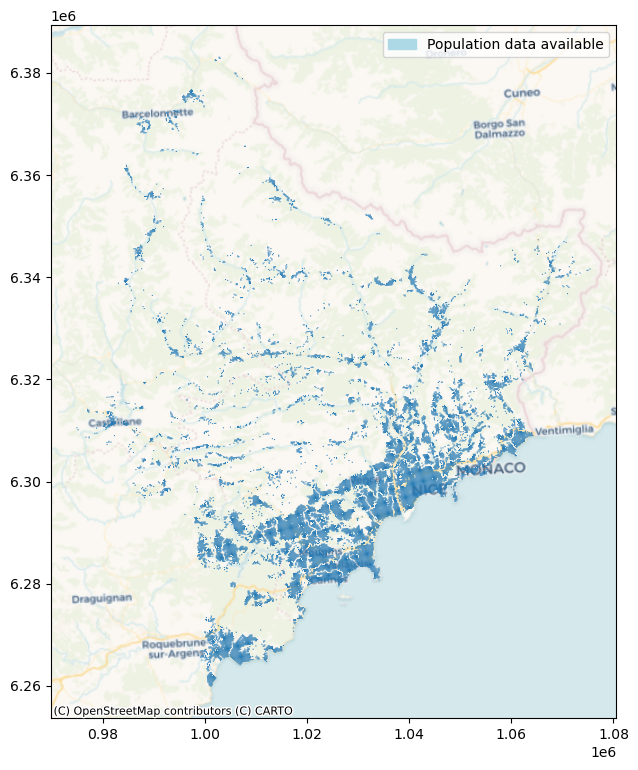

In [8]:
# Appendix A1 : check : population filter (Filosofi) on given department
ax = dpt_population.plot(figsize=(9, 9))
# Add basemap
contextily.add_basemap(ax, crs=dpt_population.crs, source=contextily.providers.CartoDB.Voyager)
# Manually create legend handles and labels
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='lightblue')]
legend_labels = ["Population data available"]
# Add custom legend
ax.legend(legend_handles, legend_labels)
plt.show()

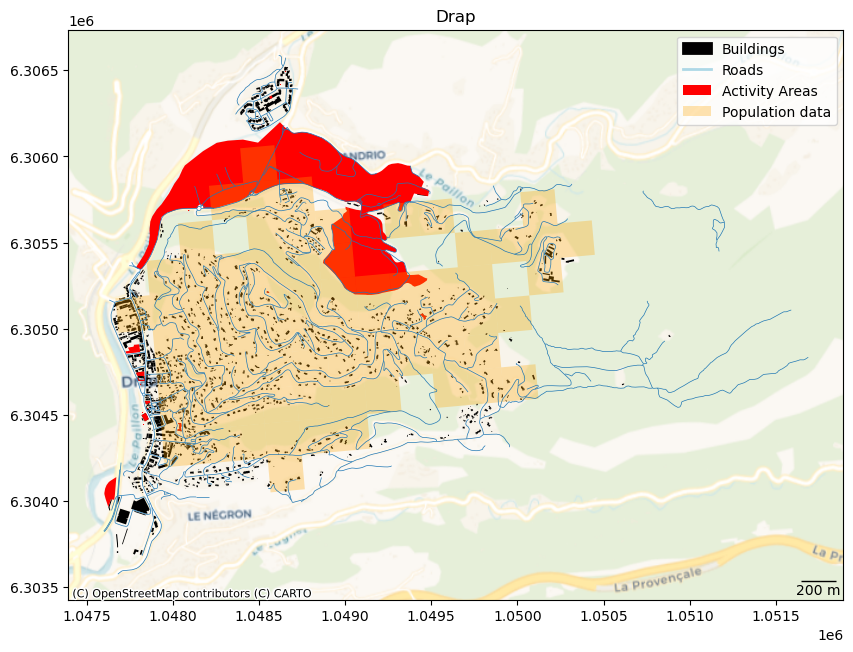

In [9]:
# Appendix A2 : Map of subset
# Create custom legend handles
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color='black', lw=2, label='Buildings'),  # For buildings
    plt.Line2D([0], [0], color='lightblue', lw=2, label='Roads'), # For roads
    plt.Rectangle((0, 0), 1, 1, color='red', ec='none', label='Activity Areas'),  # For activity areas
    plt.Rectangle((0, 0), 1, 1, fc='orange', ec='none', label='Population data', alpha=0.3)  # For population
]
# Create a plot with building_clean
ax = building_subset.plot(figsize=(10, 10), color='black')
# Plot road_clean on the same map
road_subset.plot(ax=ax, linewidth=0.5)
# Plot activity areas on the same map
activity_area_subset.plot(ax=ax, color='red')
# Plot population on the same map
ax = population_subset.plot(ax=ax, alpha=0.3, color='orange')
# Add title & legend
plt.title(subset)
ax.legend(handles=legend_handles)
scalebar = AnchoredSizeBar(ax.transData, 200, '200 m', 'lower right', frameon=False)
ax.add_artist(scalebar)
# Add basemap
contextily.add_basemap(ax, crs=population_subset.crs, source=contextily.providers.CartoDB.Voyager)